FGL-3SR for analysis of connectomes
==================================================================

This example uses FGL-3SR in order to learn functional connectivity between
regions of interest.

Load ADHD dataset and MSDL atlas
--------------------------------

In [1]:
from nilearn import datasets
adhd_data = datasets.fetch_adhd(n_subjects=1)

/home/ph/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


We use probabilistic regions of interest (ROIs) from the MSDL atlas.

In [2]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

Region signals extraction
-------------------------
We extract regions time series.

In [4]:
subjects_timeseries = []
adhd_labels = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    is_adhd = phenotypic['adhd']
    subjects_timeseries.append(time_series)
    adhd_labels.append(is_adhd)

/usr/local/lib/python3.5/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


FGL-3SR
-------------------------
We learn functional connectivity between regions of interest with FGL-3SR.

In [5]:
import GL_3SR

beta = 1500.
alpha = .0001

Y = subjects_timeseries[0].T
N = Y.shape[0]

In [6]:
gl3sr = GL_3SR.FGL_3SR(trace=N, beta=beta, alpha=alpha, maxit=100, verbose=True, cv_crit=10e-12)
gl3sr.fit(Y)

FGL-3SR start
 99.0 %

In [7]:
import numpy as np

X, H, lbd, err = gl3sr.get_coeffs()
Lpred = X.dot(np.diag(lbd)).dot(X.T)
Wpred = np.diag(np.diag(Lpred)) - Lpred
Wpred = (Wpred + Wpred.T)/2
Wpred *= (Wpred>np.mean(Wpred))

Estimate weight matrix

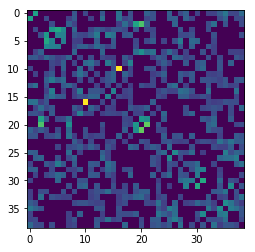

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(Wpred)

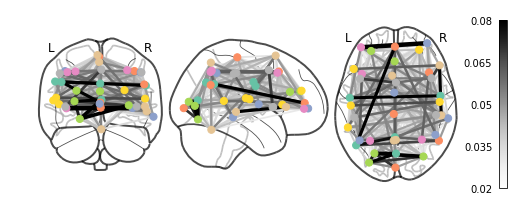

In [9]:
from nilearn import plotting

plotting.plot_connectome(Wpred, msdl_coords, colorbar=True, edge_cmap='Greys',
                         edge_vmin=.02, edge_vmax=.08, title='')

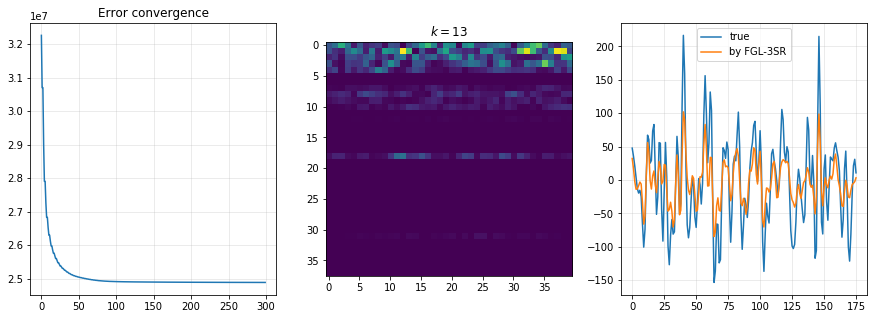

In [10]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rcParams["figure.figsize"] = (15, 5)

plt.subplot(131)
plt.plot(err[1:])
plt.grid(alpha=.3)
plt.title("Error convergence")

plt.subplot(132)
plt.title('$k = $' + str(np.sum(np.sum(abs(H), 1)>0)))
plt.imshow(abs(H[1:, :40]))

plt.subplot(133)
plt.plot(Y[0], label="true")
plt.plot(X.dot(H)[0], label='by FGL-3SR')
plt.grid(alpha=.3)
plt.legend()